## Data606 - Capstone Project
```
Group H
Malav Patel, Kent Butler
Prof. Unal Sokaglu
```

The project is about climate data analysis and performing time-series analysis.

# Research

### References

Some explanations of earth sciences statistics:
https://pjbartlein.github.io/REarthSysSci/ltms-and-anomalies.html

NOAA PSL NCEP-NCAR datasets:  https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html

NOAA PSL, other recognized data sources directory: https://psl.noaa.gov/data/help/othersources/

Global environmental policy timeline, https://www.boell.de/en/2022/05/28/international-environmental-policy-timeline

OECD convergence of policy, climate,and economy: https://www.oecd.org/

NASA climate time machine: https://climate.nasa.gov/interactives/climate-time-machine

### Factoids

* All of the plastic waste produced in the world in 2019 alone weighs as much as 35,000 Eiffel Towers – 353 million tons  - [*Organization for Economic Cooperation and Development (OECD)*](https://www.boell.de/en/2022/05/28/international-environmental-policy-timeline)



## Application Parameters

Note: algorithm tuning is done with declaration of the model.

In [100]:
import pandas as pd
from datetime import datetime as dt
import datetime

In [101]:
debug = True

DRIVE_PATH = "/content/drive/MyDrive/data606"

# Set the location of this script in GDrive
SCRIPT_PATH = DRIVE_PATH + "/src/"

# Root Path of the data on the cloud drive
DATA_ROOT = DRIVE_PATH + "/data/"

# Model to use
MODEL_NAME = "LSTMv2"

# Number of samples to work with - will be split  into train/test
SAMPLE_SIZE = 5000

# Device to run on
run_on_device =  'cpu' # 'cuda'

# Start including data from this date
START_DATE =  pd.to_datetime(dt.fromisoformat('1950-01-01'))
# Stop including data after this date
END_DATE = pd.to_datetime(dt.fromisoformat('2022-12-31'))

# Label to predict
TARGET_LABEL = 'LandAndOceanAverageTemperature'

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
%cd $SCRIPT_PATH

/content/drive/MyDrive/data606/src


In [104]:
# Load util class
%run -i "./ProjectUtil.ipynb"

In [105]:
# Load util class
%run -i "./WindowGenerator.ipynb"

              A   B      C
2011-01-02   97   1  0.125
2011-01-03   98   2  0.250
2011-01-04   99   3  0.375
2011-01-05  100   4  0.500
2011-01-06  101   5  0.625
2011-01-07  102   6  0.750
2011-01-08  103   7  0.875
2011-01-09  104   8  1.000
2011-01-10  105   9  1.125
2011-01-11  106  10  1.250
2011-01-12  107  11  1.375
Shape: (11, 3)
input_slice: slice(0, 4, None)
labels_slice: slice(4, 5, None)
input_indices: [0 1 2 3]
label_indices: [4]
---------
 Total window size: 5
Input indices: [0 1 2 3]
Label indices: [4]
Label column name(s): ['A']
Frames: (7, 5, 3)
First frame: [[ 97.      1.      0.125]
 [ 98.      2.      0.25 ]
 [ 99.      3.      0.375]
 [100.      4.      0.5  ]
 [101.      5.      0.625]]
Last frame: [[103.      7.      0.875]
 [104.      8.      1.   ]
 [105.      9.      1.125]
 [106.     10.      1.25 ]
 [107.     11.      1.375]]
Slicing inputs with: slice(0, 4, None)
Slicing labels with: slice(4, 5, None)
--- Inputs ---
(7, 4, 3)
--- Labels ---
(7, 1, 3)
enumera

# Data Load

In [106]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10,6)
import warnings

In [107]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline

---

**Initial Data Load**

---

*NOTE:  Is there a way to build a re-usable data load and normalization routine? For at least the simple datasets? And would that be helpful.*

### Global Temperature Data


This is a set of global long-term average monthly temperatures in Celsius.

Derived from multiple sets of data from:

`Global Historical Climatology Network (GHCN2), Peterson and Vose, 1997); the Atmospheric Environment Service/Environment Canada; the State Hydrometeorological Institute, St. Petersburg, Russia; Greenland—from the GC-Net (Steffen et al., 1996); the Automatic Weather Station Project (courtesy of Charles R. Stearns at the University of Wisconsin-Madison); the Global Synoptic Climatology Network (Dataset 9290c, courtesy of National Climatic Data Center); and the Global Surface Summary of Day (GSOD) (NCDC)`.

Monthly averages of station air temperature (T) were interpolated to a 0.5 degree by 0.5 degree latitude/longitude grid, where the grid nodes are centered on the 0.25 degree.

In [108]:
df = pd.read_csv(DATA_ROOT + 'GlobalTemperatures.csv')

In [109]:
df.shape

(3192, 9)

In [110]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LandAverageTemperature,3180.0,8.374731,4.381310,-2.080,4.31200,8.6105,12.54825,19.021
LandAverageTemperatureUncertainty,3180.0,0.938468,1.096440,0.034,0.18675,0.3920,1.41925,7.880
LandMaxTemperature,1992.0,14.350601,4.309579,5.900,10.21200,14.7600,18.45150,21.320
LandMaxTemperatureUncertainty,1992.0,0.479782,0.583203,0.044,0.14200,0.2520,0.53900,4.373
LandMinTemperature,1992.0,2.743595,4.155835,-5.407,-1.33450,2.9495,6.77875,9.715
LandMinTemperatureUncertainty,1992.0,0.431849,0.445838,0.045,0.15500,0.2790,0.45825,3.498
LandAndOceanAverageTemperature,1992.0,15.212566,1.274093,12.475,14.04700,15.2510,16.39625,17.611
LandAndOceanAverageTemperatureUncertainty,1992.0,0.128532,0.073587,0.042,0.06300,0.1220,0.15100,0.457


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB


In [112]:
df.head(3)

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
df.tail(3)

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
3189,2015-10-01,10.801,0.102,16.450,0.059,5.232,0.115,16.290,0.062
3190,2015-11-01,7.433,0.119,12.892,0.093,2.157,0.106,15.252,0.063
3191,2015-12-01,5.518,0.100,10.725,0.154,0.287,0.099,14.774,0.062


**Condition dataset**

In [114]:
# convert to a Timestamp
df['date'] = pd.to_datetime(df['dt'])

In [115]:
# Truncate by our global date bounds
df = df[df['date'] >= START_DATE]
df = df[df['date'] <= END_DATE]

In [116]:
# Drop uncertainties until we know what to do with them
DROP_LIST = ['LandAverageTemperatureUncertainty','LandMaxTemperatureUncertainty','LandMinTemperatureUncertainty','LandAndOceanAverageTemperatureUncertainty']

In [117]:
df.drop(DROP_LIST, axis=1, inplace=True)

In [118]:
df.reset_index(inplace=True)

In [119]:
df.tail(3)

,index,dt,LandAverageTemperature,LandMaxTemperature,LandMinTemperature,LandAndOceanAverageTemperature,date
789,3189,2015-10-01,10.801,16.450,5.232,16.290,2015-10-01
790,3190,2015-11-01,7.433,12.892,2.157,15.252,2015-11-01
791,3191,2015-12-01,5.518,10.725,0.287,14.774,2015-12-01


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   index                           792 non-null    int64         
 1   dt                              792 non-null    object        
 2   LandAverageTemperature          792 non-null    float64       
 3   LandMaxTemperature              792 non-null    float64       
 4   LandMinTemperature              792 non-null    float64       
 5   LandAndOceanAverageTemperature  792 non-null    float64       
 6   date                            792 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 43.4+ KB


In [121]:
# Sort values by timestamp (not necessary in this case)
df = df.sort_values(by='date')

**Confirm time intervals**

In [122]:
# Check time intervals
df['interval'] = df.date - df.date.shift(1)

df[['date', 'interval']].head()

,date,interval
0,1950-01-01,NaT
1,1950-02-01,31 days
2,1950-03-01,28 days
3,1950-04-01,31 days
4,1950-05-01,30 days


In [123]:
print(f"{df['interval'].value_counts()}")

31 days    461
30 days    264
28 days     50
29 days     16
Name: interval, dtype: int64


In [124]:
df.drop(['interval'], axis=1, inplace=True)

---

**Visualize**

---

In [125]:
COLS = ['LandAverageTemperature',	'LandMaxTemperature',	'LandMinTemperature',	'LandAndOceanAverageTemperature']

**Individual data points**

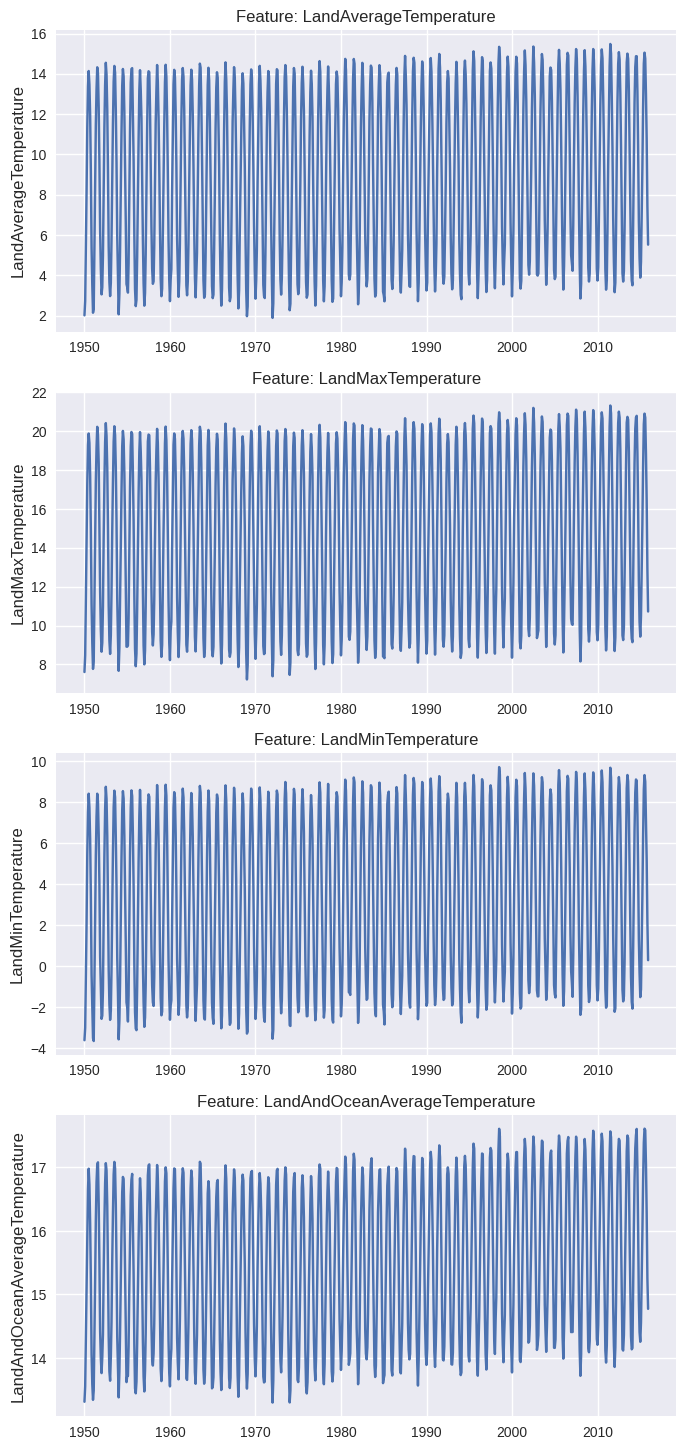

In [126]:
f, ax = plt.subplots(nrows=len(COLS), ncols=1, figsize=(8, 18))

for i, col in enumerate(COLS):
  sns.lineplot(x=df.date, y=df[col].fillna(np.inf), ax=ax[i])
  ax[i].set_title(f'Feature: {col}', fontsize=12)
  ax[i].set_ylabel(ylabel=f'{col}', fontsize=12)
  ax[i].set_xlabel('')

We can see an overall trend moving upward. No visible data dropouts.

**Missing Data**

In [127]:
df.isna().value_counts()

index  dt     LandAverageTemperature  LandMaxTemperature  LandMinTemperature  LandAndOceanAverageTemperature  date 
False  False  False                   False               False               False                           False    792
dtype: int64

Set has no missing data.

---

**CO2 Data**

---

In [128]:
# Load util class
%run -i "./Integrate_Dataset.ipynb"

### Loading data/content/drive/MyDrive/data606/data/atmospheric-co2.csv::
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               720 non-null    int64  
 1   month                              720 non-null    int64  
 2   Decimal Date                       720 non-null    float64
 3   co2                                710 non-null    float64
 4   co2_seas                           710 non-null    float64
 5   Carbon Dioxide Fit (ppm)           707 non-null    float64
 6   Seasonally Adjusted CO2 Fit (ppm)  707 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 39.5 KB
isna() value counts::
Using date format: 01/{months}/{years}
Doing date conversion ------


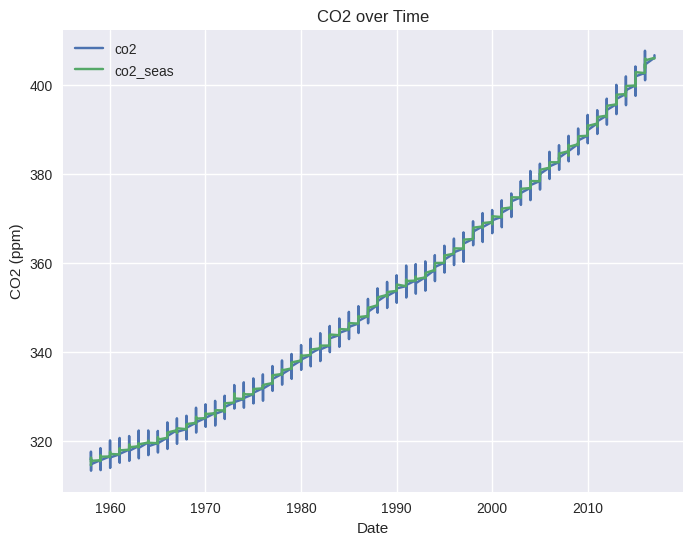

------ Interval Counts - should be on the month ------
1 days      660
354 days     44
355 days     15
Name: interval, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 719
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   co2       710 non-null    float64       
 1   co2_seas  710 non-null    float64       
 2   date      720 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2)
memory usage: 22.5 KB
Merging by date ------


In [129]:
# merge_dataset(data_path, df_aggr, start_date, end_date, feature_map, impute_method='bfill', date_col=None, year_col=None, day_col=None,month_col=None, date_func=None):

df_merge = merge_dataset(DATA_ROOT + "atmospheric-co2.csv",
                          df,
                          START_DATE, END_DATE,
                          feature_map={'Carbon Dioxide (ppm)':'co2', 'Seasonally Adjusted CO2 (ppm)':'co2_seas'},
                          date_map={'Year':'year','Month':'month'})

In [130]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 57
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   index                           58 non-null     int64         
 1   dt                              58 non-null     object        
 2   LandAverageTemperature          58 non-null     float64       
 3   LandMaxTemperature              58 non-null     float64       
 4   LandMinTemperature              58 non-null     float64       
 5   LandAndOceanAverageTemperature  58 non-null     float64       
 6   date                            58 non-null     datetime64[ns]
 7   co2                             58 non-null     float64       
 8   co2_seas                        58 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 4.5+ KB


In [131]:
# Load util class
#%run -i "./Integrate_CO2_Dataset.ipynb"

In [132]:
#df_merge = merge_co2_dataset(DATA_ROOT + "atmospheric-co2.csv",
#                          df,
#                          START_DATE, END_DATE,
#                          {'Carbon Dioxide (ppm)':'co2', 'Seasonally Adjusted CO2 (ppm)':'co2_seas'})

---

**Merge seaice**

---

### Loading data/content/drive/MyDrive/data606/data/seaice.csv::
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26354 entries, 0 to 26353
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          26354 non-null  int64  
 1   month         26354 non-null  int64  
 2   day           26354 non-null  int64  
 3   ice_extent    26354 non-null  float64
 4   ice_missing   26354 non-null  float64
 5    Source Data  26354 non-null  object 
 6   hemisphere    26354 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 1.4+ MB
isna() value counts::
Using date format: {days}/{months}/{years}
Doing date conversion ------


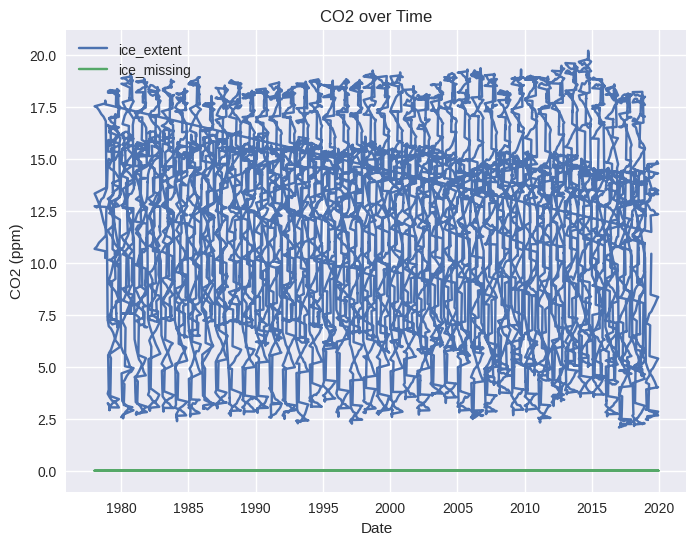

------ Interval Counts - should be on the month ------
1 days         13396
31 days         4560
30 days         3032
2 days          1770
61 days          740
28 days          568
29 days          190
59 days          164
62 days          108
-322 days        100
-235 days         90
-87 days          88
-28 days          82
-117 days         72
-176 days         70
-293 days         68
-292 days         66
-58 days          64
-29 days          64
-265 days         64
-206 days         64
-147 days         62
-234 days         60
-86 days          58
-263 days         54
-115 days         52
-56 days          52
-204 days         50
-174 days         50
-145 days         48
60 days           48
-146 days         34
-205 days         34
-57 days          32
-323 days         30
-116 days         26
-264 days         24
-175 days         24
-262 days         20
-294 days         16
-55 days          16
-173 days         16
-321 days         16
-114 days         12
-203 days         12


In [133]:
df_merge = merge_dataset(DATA_ROOT + "seaice.csv",
                        df_merge,
                        START_DATE, END_DATE,
                        feature_map={'     Extent':'ice_extent','    Missing':'ice_missing'},
                        date_map={' Month':'month','Year':'year',' Day':'day'})

---

**Merge Weather Data**

---

### Loading data/content/drive/MyDrive/data606/data/finalDatasetWithRain.csv::
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622392 entries, 0 to 622391
Data columns (total 71 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   lat       622392 non-null  float64
 1   lon       622392 non-null  float64
 2   time      622392 non-null  object 
 3   air_x     622392 non-null  float64
 4   air_y     440861 non-null  float64
 5   air       0 non-null       float64
 6   lftx4     311196 non-null  float64
 7   cfnlf     622392 non-null  float64
 8   cfnsf     622392 non-null  float64
 9   pres_x    321908 non-null  float64
 10  pres_y    321908 non-null  float64
 11  pres_x.1  488723 non-null  float64
 12  pres_y.1  488718 non-null  float64
 13  pres_x.2  390709 non-null  float64
 14  pres_y.2  390709 non-null  float64
 15  cprat     622392 non-null  float64
 16  csdlf     622392 non-null  float64
 17  csdsf     622392 non-null  float64
 18  csulf

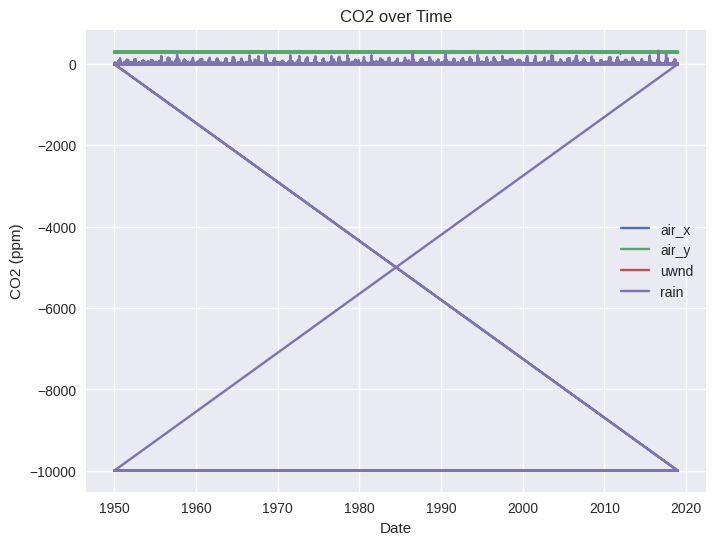

------ Interval Counts - should be on the month ------
1 days         604824
-25201 days        23
Name: interval, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 604848 entries, 731 to 622391
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   air_x   604848 non-null  float64       
 1   air_y   428434 non-null  float64       
 2   uwnd    428434 non-null  float64       
 3   rain    453636 non-null  float64       
 4   date    604848 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4)
memory usage: 27.7 MB
Merging by date ------


In [134]:
df_merge = merge_dataset(DATA_ROOT + "finalDatasetWithRain.csv",
                             df_merge,
                             START_DATE, END_DATE,
                             feature_map={'air_x':'air_x','air_y':'air_y','uwnd':'uwnd','rain':'rain'},
                             date_col='time')

---

**Assess Merged Data**

---

In [135]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1488 entries, 0 to 1487
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   index                           1488 non-null   int64         
 1   dt                              1488 non-null   object        
 2   LandAverageTemperature          1488 non-null   float64       
 3   LandMaxTemperature              1488 non-null   float64       
 4   LandMinTemperature              1488 non-null   float64       
 5   LandAndOceanAverageTemperature  1488 non-null   float64       
 6   date                            1488 non-null   datetime64[ns]
 7   co2                             1488 non-null   float64       
 8   co2_seas                        1488 non-null   float64       
 9   ice_extent                      1488 non-null   float64       
 10  ice_missing                     1488 non-null   float64       
 11  air_

In [136]:
# Set data as index
df_merge.set_index('date', inplace=True)

In [137]:
# Drop  unnecessary columns
df_merge.drop(columns=['dt','index'], inplace=True)

In [138]:
df_merge.head()

,LandAverageTemperature,LandMaxTemperature,LandMinTemperature,LandAndOceanAverageTemperature,co2,co2_seas,ice_extent,ice_missing,air_x,air_y,uwnd,rain
date,,,,,,,,,,,,
1980-01-01,2.956,8.468,-2.457,13.812,338.01,338.0,14.2,0.0,278.47998,283.50000,-0.819992,-9999.000000
1980-01-01,2.956,8.468,-2.457,13.812,338.01,338.0,14.2,0.0,284.53000,280.66000,4.199997,-9999.000000
1980-01-01,2.956,8.468,-2.457,13.812,338.01,338.0,14.2,0.0,285.72998,289.46002,2.509994,-9999.000000
1980-01-01,2.956,8.468,-2.457,13.812,338.01,338.0,14.2,0.0,287.56000,290.83002,-1.270004,2.398697
1980-01-01,2.956,8.468,-2.457,13.812,338.01,338.0,14.2,0.0,286.55000,284.78000,-4.770004,3.721700


In [139]:
df_merge.describe().T

,count,mean,std,min,25%,50%,75%,max
LandAverageTemperature,1488.0,3.435871,0.399733,2.710000,3.165000,3.352000,3.732000,4.579000
LandMaxTemperature,1488.0,8.853677,0.442517,8.095000,8.555000,8.818000,9.245000,10.084000
LandMinTemperature,1488.0,-1.861387,0.391082,-2.598000,-2.134000,-1.776000,-1.650000,-0.818000
LandAndOceanAverageTemperature,1488.0,13.968129,0.191460,13.566000,13.818000,13.945000,14.117000,14.417000
co2,1488.0,369.660000,17.494683,338.010000,355.990000,369.140000,385.070000,399.850000
co2_seas,1488.0,369.637419,17.492824,338.000000,355.960000,369.120000,385.050000,399.830000
ice_extent,1488.0,10.370855,3.327682,5.967000,6.923000,11.144500,13.634000,14.319000
ice_missing,1488.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
air_x,1488.0,286.878097,4.012521,275.400000,284.045000,287.060000,289.785000,298.360000
air_y,1054.0,288.227282,3.405550,278.000000,286.300000,288.270020,290.268765,300.300000


---

**Assess correlations**

---

In [140]:
# Assess correlations between all data columns
df_corr = df_merge.corr()

In [141]:
# Identify the columns which have medium to strong correlation with target
df_corr_cols = df_corr[df_corr[TARGET_LABEL] > 0.5]

In [142]:
# Drop the target from the correlation results in case we want to use this reduced set
#    in place of the full set
df_corr_cols = df_corr_cols.drop(columns=[])

In [143]:
# Extract just the column names
corr_cols = df_corr_cols.index.values

In [144]:
if debug:
  print(corr_cols)

['LandAverageTemperature' 'LandMaxTemperature' 'LandMinTemperature'
 'LandAndOceanAverageTemperature' 'co2' 'co2_seas']


Text(0.5, 1.0, 'Heatmap of correlation among variables')

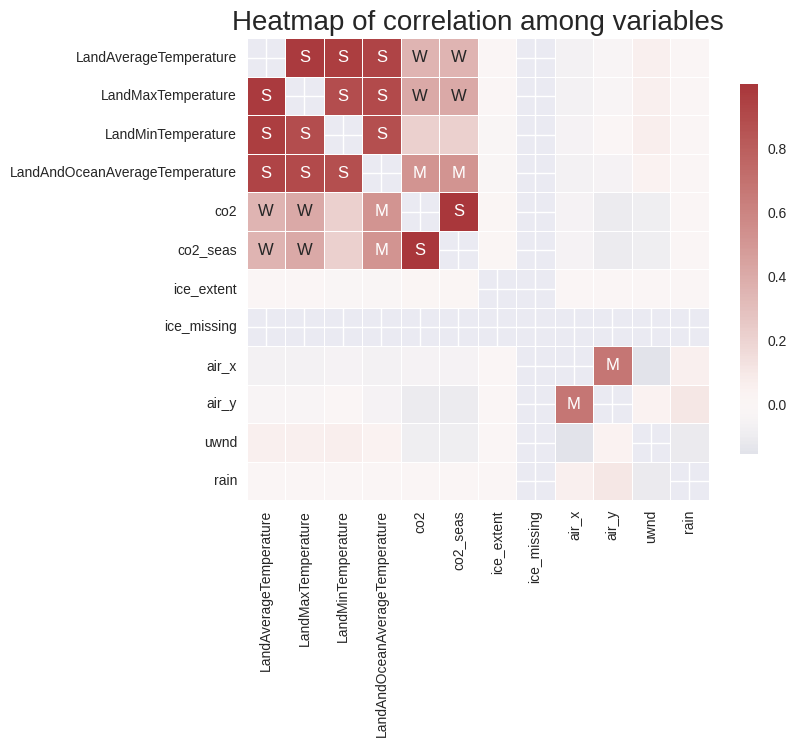

In [145]:
# Add labels
labels = np.where(np.abs(df_corr) > 0.75, 'S',
                  np.where(np.abs(df_corr) > 0.5, 'M',
                           np.where(np.abs(df_corr) > 0.25, 'W', '')))
# Plot the matrix
plt.figure(figsize=(8,6))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt = '', linewidths = .5,
            cmap='vlag', cbar_kws={'shrink':0.8});
plt.title('Heatmap of correlation among variables', fontsize=20)

**Assess Periodicity**

```
# removed kendalltau analysis
# Replace with fft graph of major freqs?
```


**Resampling**

Time intervals are already at monthly target.

In [146]:
df_merge.shape

(1488, 12)

Ready for time series modeling.

---

**Prepare for Modeling**

---

**Basic model params**

In [147]:
# History lookback in network
INPUT_WINDOW = 60
# How far forward to predict
LABEL_WINDOW = 1
# Ratio of test data to train data - used for split
TEST_RATIO = 0.2
# 0..1 percent of data to use as validation
VALIDATION_RATIO = 0.1
# Num epochs
NUM_EPOCHS = 300

**Extract label data**

---

**Data pre-processing**

---

**Extract labels**

Time series creates a supervised learning problem out of moving data.

**Dataset stats**

In [148]:
NUM_FEATURES = len(df_merge.columns)

In [149]:
# Keep rows aside for post validation?
TOTAL_ROWS = df_merge.shape[0]
NUM_VALIDATION = math.floor(TOTAL_ROWS * VALIDATION_RATIO)
WORKING_ROWS = TOTAL_ROWS - NUM_VALIDATION

In [150]:
# Split non-validation rows into train/test
NUM_TEST = math.floor(WORKING_ROWS * TEST_RATIO)
NUM_TRAIN = WORKING_ROWS - NUM_TEST

In [151]:
print(f'Num features: {NUM_FEATURES}')
print(f'Total rows: {TOTAL_ROWS}')
print(f'Validation rows: {NUM_VALIDATION}')
print(f'Train rows: {NUM_TRAIN}')
print(f'Test rows: {NUM_TEST}')

Num features: 12
Total rows: 1488
Validation rows: 148
Train rows: 1072
Test rows: 268


**Split into Train/Test**

In [152]:
df_train = df_merge.iloc[:NUM_TRAIN, :]
df_test = df_merge.iloc[NUM_TRAIN:NUM_TRAIN+NUM_VALIDATION, :]
df_val = df_merge.iloc[NUM_TRAIN+NUM_VALIDATION:, :]

In [153]:
y_train = df_train[TARGET_LABEL]
y_test = df_test[TARGET_LABEL]
y_val = df_val[TARGET_LABEL]

In [154]:
if debug:
  print(f'df_train: {df_train.shape}')
  print(f'y_train: {y_train.shape}')
  print(f'df_test: {df_test.shape}')
  print(f'y_test: {y_test.shape}')
  print(f'df_val: {df_val.shape}')
  print(f'y_val: {y_val.shape}')

df_train: (1072, 12)
y_train: (1072,)
df_test: (148, 12)
y_test: (148,)
df_val: (268, 12)
y_val: (268,)


**Scale data**

Doing this **after** the split means that training data doesn't get unfair advantage of looking ahead into the 'future' during test & validation.

In [155]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [156]:
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer,  QuantileTransformer, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [157]:
# Create small pipeline for numerical features
numeric_pipeline = Pipeline(steps = [('impute', SimpleImputer(strategy='mean')),
                                    ('scale', MinMaxScaler())])

In [158]:
# get names of numerical features
con_lst = df_train.select_dtypes(include='number').columns.to_list()

In [159]:
# Transformer for applying Pipelines
column_transformer = ColumnTransformer(transformers = [('number', numeric_pipeline, con_lst)])

In [160]:
# Transform data features
X_train_tx = column_transformer.fit_transform(df_train)
X_test_tx = column_transformer.transform(df_test)
X_val_tx = column_transformer.transform(df_val)
X_train_tx.shape, X_test_tx.shape, X_val_tx.shape

((1072, 12), (148, 12), (268, 12))

In [161]:
# Transform labels
label_scaler = MinMaxScaler()
y_train_tx = label_scaler.fit_transform(y_train.values.reshape(-1, 1))

In [162]:
if debug:
  print(f'X_train:scaled: {X_train_tx[0]}')
  print(f'y_train:scaled: {y_train_tx[0]}')

X_train:scaled: [0.13162119 0.18753142 0.07921348 0.28907168 0.         0.
 0.98575192 0.         0.13414547 0.24663677 0.54513445 0.        ]
y_train:scaled: [0.28907168]


**Extract X and y**

Normally we would do this by explicitly extracting data from our df.

However for a time series, we're going to create many small supervised learning sets, so a set of X and y pairs.

We should end up with data in a shape ready for batched network input:

`batches X time_steps X features`



In [163]:
#windowing = TfWindowGenerator(input_width=INPUT_WINDOW,
#                              label_width=LABEL_WINDOW,
#                              shift=LABEL_WINDOW,
#                              label_columns=[TARGET_LABEL])

In [164]:
# Pull X and y out of Training data
#X, y = windowing.generate(df_train)

In [165]:
# testing more direct extraction
#X = np.asarray(df.drop(columns=[TARGET_LABEL]))
#X = np.asarray(df)

In [166]:
if debug:
  print(f'X_train_tx: {X_train_tx.shape}')
  print(f'y_train_tx: {y_train_tx.shape}')

X_train_tx: (1072, 12)
y_train_tx: (1072, 1)


---

**Modeling**

---

In [167]:
# These are the features we are going to be modeling
COLS = df_merge.columns

**Slice into Batches**

In [168]:
# TensorFlow has a util for creating its batching DataSet from this type of data
#tf_dataset = tf.keras.utils.timeseries_dataset_from_array(
#    data=X,
#    targets=None,
#    sequence_length=INPUT_WINDOW,
#    sequence_stride=1,
#    shuffle=True,
#    batch_size=32,)

In [169]:
#ds = windowing.make_dataset(X, y)

In [170]:
ds = tf.keras.utils.timeseries_dataset_from_array(
    data=X_train_tx,
    targets=y_train_tx,
    sequence_length=INPUT_WINDOW)

In [171]:
ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 12), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

**Prep GPU**

In [172]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


**Build model**

In [173]:
# Load model class
%run -i "./Model_LSTMv2.ipynb"

In [174]:
model = ModelLSTMv2(window_size=INPUT_WINDOW, num_epochs=NUM_EPOCHS, debug=debug)

### Building ModelLSTMv2::


**Train model**

In [175]:
#model.train(X, y, NUM_FEATURES)
model.train(dataset=ds, num_features=NUM_FEATURES)

Epoch 1/300
8/8 [==============================] - 12s 72ms/step - loss: 0.1689
Epoch 2/300
8/8 [==============================] - 0s 53ms/step - loss: 0.1911
Epoch 3/300
8/8 [==============================] - 0s 53ms/step - loss: 0.2815
Epoch 4/300
8/8 [==============================] - 0s 52ms/step - loss: 0.1563
Epoch 5/300
8/8 [==============================] - 0s 54ms/step - loss: 0.2683
Epoch 6/300
8/8 [==============================] - 0s 52ms/step - loss: 0.1964
Epoch 7/300
8/8 [==============================] - 0s 52ms/step - loss: 0.2267
Epoch 8/300
8/8 [==============================] - 0s 52ms/step - loss: 0.1418
Epoch 9/300
8/8 [==============================] - 0s 52ms/step - loss: 0.2216
Epoch 10/300
8/8 [==============================] - 0s 54ms/step - loss: 0.1509
Epoch 11/300
8/8 [==============================] - 0s 50ms/step - loss: 0.1849
Epoch 12/300
8/8 [==============================] - 0s 54ms/step - loss: 0.1646
Epoch 13/300
8/8 [==============================

**Test Predictions**

In [176]:
num_predictions = y_test.shape[0]-INPUT_WINDOW

preds = []
y_test_vals = []

In [177]:
for p in range(num_predictions):
  X_pred = X_test_tx[p:p+INPUT_WINDOW,:].reshape(-1, INPUT_WINDOW, NUM_FEATURES)
  y_test_vals.append(y_test[p+INPUT_WINDOW])
  # Predict
  pred = model.predict(X_pred)
  # Scale and save
  preds.append(label_scaler.inverse_transform(pred))

1/1 [==============================] - 0s 22ms/step


In [178]:
preds = np.array(preds).reshape(num_predictions)

**Analyze results**

In [179]:
df_results = pd.DataFrame({'y_test': y_test_vals,
                          'preds': preds},
                           index=[i+1 for i in range(num_predictions)])

In [180]:
df_results

,y_test,preds
1,13.719,13.893664
2,13.719,13.893655
3,13.719,13.893604
4,13.719,13.893567
5,13.719,13.893541
...,...,...
84,14.208,13.892346
85,14.208,13.892404
86,14.208,13.892404
87,14.208,13.892473


<Axes: >

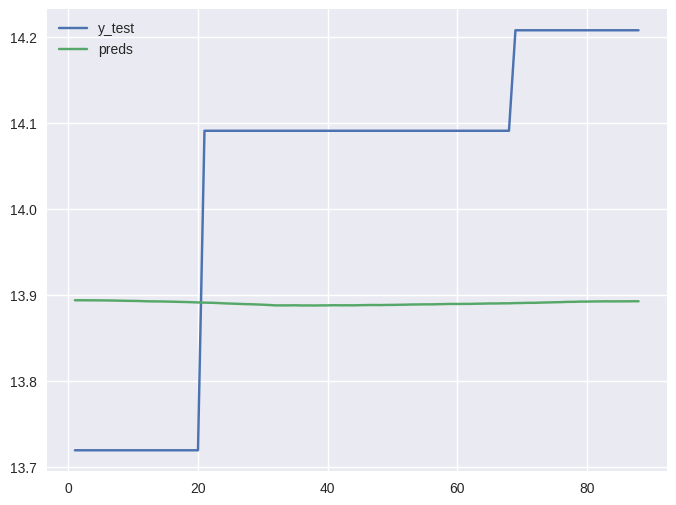

In [181]:
df_results.plot()

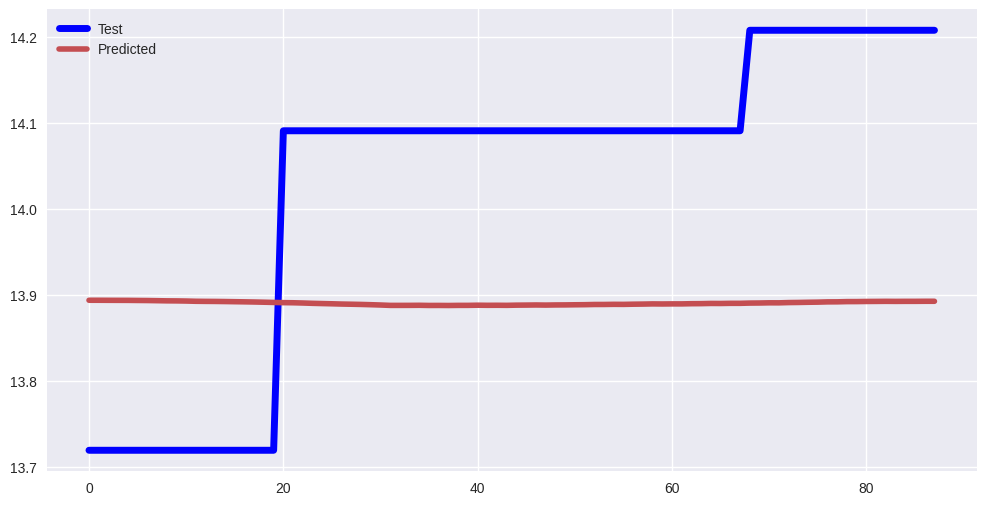

In [182]:
plt.figure(figsize=(12,6))
plt.plot(y_test_vals, 'blue', linewidth=5)
plt.plot(preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.show()

In [183]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [184]:
# Calculate MAPE
m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(y_test_vals, preds)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>

In [185]:
mse = mean_squared_error(y_test_vals, preds)
mae = mean_absolute_error(y_test_vals, preds)
mape = m.result().numpy()/100  # adjust Keras output to match scikit
from sklearn.metrics import mean_absolute_percentage_error
sk_mape = mean_absolute_percentage_error(y_test_vals, preds)

In [186]:
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'SKMAPE: {sk_mape}')

MSE: 0.05189823903858568
MAE: 0.22165869851545794
MAPE: 0.01576446056365967
SKMAPE: 0.01576446946166972


**Journal entry**

In [187]:
# Print a journal entry for this run
print('DateTime,TargetLabel,NumFeatures,WindowSize,TestPct,MSE,MAE,MAPE,SKMAPE,Columns')
print(f'"{dt.today().strftime("%Y%m%d-%H%M")}",{TARGET_LABEL},{NUM_FEATURES},{INPUT_WINDOW},{TEST_RATIO},{mse},{mae},{mape},{sk_mape},"{COLS}"')

DateTime,TargetLabel,NumFeatures,WindowSize,TestPct,MSE,MAE,MAPE,SKMAPE,Columns
"20231029-1721",LandAndOceanAverageTemperature,12,60,0.2,0.05189823903858568,0.22165869851545794,0.01576446056365967,0.01576446946166972,"Index(['LandAverageTemperature', 'LandMaxTemperature', 'LandMinTemperature',
       'LandAndOceanAverageTemperature', 'co2', 'co2_seas', 'ice_extent',
       'ice_missing', 'air_x', 'air_y', 'uwnd', 'rain'],
      dtype='object')"
